# EDA for 'Big Debt Crisis' by Ray Dalio


## 1. Setup and Data Loading

First, we'll import the necessary libraries, set up the paths, and load the book's text and structure. This includes a helper function to ensure the required NLTK data packages (`punkt` for tokenization and `stopwords` for analysis) are downloaded.


In [1]:
import sys
import os
import re
import ebooklib
from ebooklib import epub
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from nltk.util import bigrams
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter

# Add the src directory to the Python path
sys.path.append(os.path.abspath('../src'))
from data_ingestion import extract_text_from_epub

# --- Download necessary NLTK data ---
def download_nltk_resource(resource):
    """Checks for an NLTK resource and downloads it if not found."""
    try:
        nltk.data.find(resource)
    except LookupError:
        print(f"NLTK resource '{resource.split('/')[-1]}' not found. Downloading...")
        nltk.download(resource.split('/')[-1], quiet=True)
        print("Download complete.")

download_nltk_resource('tokenizers/punkt')
download_nltk_resource('corpora/stopwords')
download_nltk_resource('tokenizers/punkt_tab')


# --- Load Book Data ---
book_path = '../data/BigDebtCrisis_RayDalio.epub'
print("Reading EPUB file...")
book = epub.read_epub(book_path)
print("EPUB file read successfully.")

print("\nExtracting full text from the book...")
full_text = extract_text_from_epub(book_path)
print("Text extracted successfully.")

NLTK resource 'punkt_tab' not found. Downloading...


Download complete.
Reading EPUB file...
EPUB file read successfully.

Extracting full text from the book...


Text extracted successfully.


## 2. Basic Textual Analysis

Here, we'll compute some basic statistics for the entire book to get a high-level overview of its size and complexity.


In [2]:
# --- Perform basic textual analysis on the full text ---
print("Performing basic textual analysis...")
char_count = len(full_text)
words = word_tokenize(full_text.lower())
word_count = len(words)
sentences = sent_tokenize(full_text)
sentence_count = len(sentences)
avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0
unique_words = set(words)
vocab_size = len(unique_words)

print(f"Total characters: {char_count:,}")
print(f"Total words: {word_count:,}")
print(f"Total sentences: {sentence_count:,}")
print(f"Vocabulary size (unique words): {vocab_size:,}")
print(f"Average sentence length: {avg_sentence_length:.2f} words")

print("\n--- Sample of extracted text ---")
print(full_text[:500])
print("---------------------------------")


Performing basic textual analysis...


Total characters: 1,187,252
Total words: 214,469
Total sentences: 7,214
Vocabulary size (unique words): 11,692
Average sentence length: 29.73 words

--- Sample of extracted text ---






A Template


for Understanding



BIG DEBT CRISES




Ray Dalio




Table of Contents



A Template for Understanding Big Debt Crises


Acknowledgements


Introduction


PART 1: The Archetypal Big Debt Cycle


How I Think about Credit and Debt


The Template for the Archetypal Long-Term/Big Debt Cycle


Our Examination of the Cycle


The Phases of the Classic Deflationary Debt Cycle


The Early Part of the Cycle


The Bubble


The Top


The “Depression”


The “Beautiful Deleveraging”


“Pu
---------------------------------


## 3. Word Frequency Analysis

To understand the core topics, we'll analyze the frequency of words in the text, after removing common English "stopwords" (e.g., 'the', 'a', 'in').


Calculating word frequency (excluding stopwords)...
Top 20 most common words:
[('debt', 942), ('york', 758), ('times', 746), ('currency', 732), ('money', 601), ('policy', 596), ('financial', 576), ('percent', 562), ('gdp', 557), ('credit', 544), ('banks', 523), ('would', 522), ('bank', 482), ('new', 466), ('rates', 459), ('bubble', 441), ('market', 424), ('economic', 388), ('prices', 386), ('crisis', 367)]


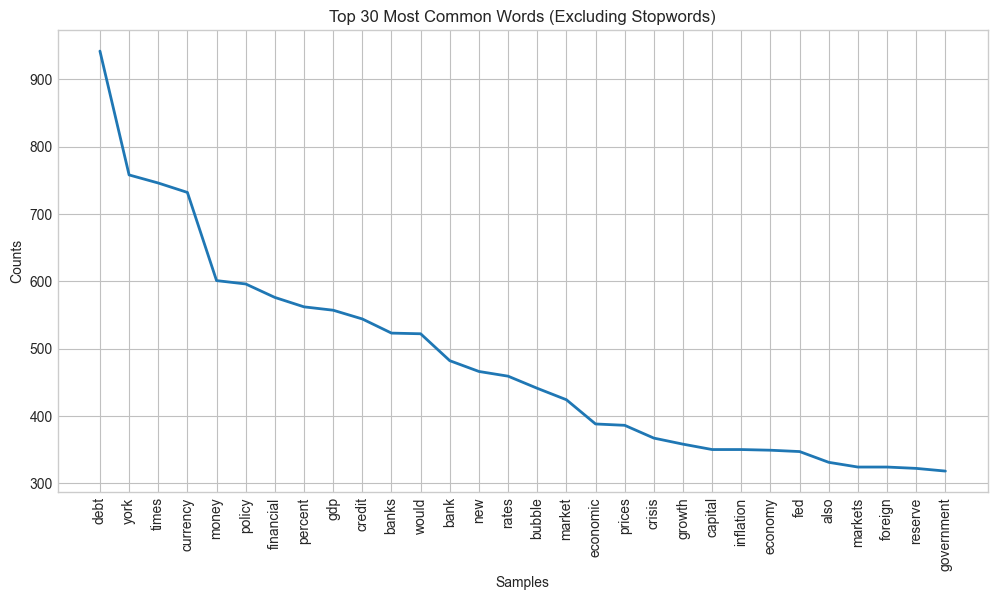

In [3]:
# --- Analyze word frequency, excluding common English stopwords ---
print("Calculating word frequency (excluding stopwords)...")
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word.isalnum() and word not in stop_words]

fdist = FreqDist(filtered_words)

print("Top 20 most common words:")
print(fdist.most_common(20))

# --- Plot the frequency distribution ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
fdist.plot(30, cumulative=False, title="Top 30 Most Common Words (Excluding Stopwords)")
plt.show()


## 4. Bigram Analysis

Bigrams are pairs of adjacent words. Analyzing them helps us identify common phrases and concepts in the book.


In [4]:
# --- Analyze bigrams (two-word phrases) ---
print("Calculating bigram frequency...")
bgs = bigrams(filtered_words)
fdist_bigrams = FreqDist(bgs)
print("Top 20 most common bigrams:")
print(fdist_bigrams.most_common(20))


Calculating bigram frequency...
Top 20 most common bigrams:
[(('york', 'times'), 673), (('policy', 'makers'), 308), (('interest', 'rates'), 207), (('federal', 'reserve'), 203), (('central', 'bank'), 142), (('new', 'york'), 142), (('financial', 'institutions'), 140), (('united', 'states'), 117), (('chart', 'deck'), 96), (('money', 'credit'), 93), (('chart', 'right'), 90), (('debt', 'gdp'), 89), (('shown', 'attribution'), 87), (('attribution', 'chart'), 87), (('real', 'fx'), 85), (('times', 'october'), 83), (('monetary', 'policy'), 81), (('stock', 'market'), 80), (('wall', 'street'), 80), (('bubble', 'phase'), 77)]


In [5]:
# --- Analyze the EPUB's structure from its metadata ---
print("Analyzing EPUB structure...")

spine_items = book.spine
print(f"Number of items in spine: {len(spine_items)}")

print("\nAll document items (HREFs):")
doc_items = [item for item in book.get_items_of_type(ebooklib.ITEM_DOCUMENT)]
for item in doc_items:
    print(f"  - {item.get_name()}")

# The hrefs are more descriptive than the spine IDs and will be used for further analysis.


Analyzing EPUB structure...
Number of items in spine: 10

All document items (HREFs):
  - text00000.html
  - text00001.html
  - text00002.html
  - text00003.html
  - text00004.html
  - text00005.html
  - text00006.html
  - text00007.html
  - ad_chapter.xhtml
  - text00008.html


## 6. Analysis for RAG Strategy

This section focuses on extracting information specifically to inform our RAG implementation


### 6.1 Extracting Part/Section Hierarchy

The book is highly structured into Parts and Sections. We'll parse the HTML of each document to extract this hierarchy using header tags (`<h1>`, `<h2>`, etc.). This will provide the `metadata.part` and `metadata.section` fields needed for filtering in the RAG pipeline.


In [6]:
# --- Dive deeper into the HTML of each document to find headers (h1, h2, etc.) ---
print("Extracting book structure from HTML headers...")
structure = {}
current_part = "Unknown Part"

for item in doc_items:
    content = item.get_content()
    soup = BeautifulSoup(content, 'html.parser')
    
    # Heuristically find part titles (often in h1 or specific classes)
    # Using a more general search for titles
    part_title = soup.find(['h1', 'h2'], class_=re.compile(r'part|title', re.I))
    if part_title and len(part_title.get_text(strip=True)) < 100: # Avoid long text passages
        current_part = part_title.get_text(strip=True)
        if current_part not in structure:
            structure[current_part] = []

    # Find chapter or section titles
    section_titles = soup.find_all(['h2', 'h3', 'h4'], class_=re.compile(r'ch|sec|title', re.I))
    for title in section_titles:
        title_text = title.get_text(strip=True)
        if title_text != current_part and len(title_text) < 150:
            structure.setdefault(current_part, []).append(title_text)

print("\nDetected Structure:")
for part, sections in structure.items():
    print(f"- {part}")
    # Remove duplicates and print first 5 sections for brevity
    unique_sections = list(dict.fromkeys(sections))
    for section in unique_sections[:5]:
        print(f"  - {section}")
    if len(unique_sections) > 5:
        print("  - ...")


Extracting book structure from HTML headers...



Detected Structure:


### 6.2 Identifying Images, Tables, and Blockquotes

Our strategy requires special handling for non-textual or distinct elements:
- **Images**: Will be stripped, but we'll store metadata about their existence.
- **Tables**: The text within them should be preserved.
- **Blockquotes**: Should be kept in single chunks to preserve the integrity of quotations.

This analysis counts these elements across the book.


In [7]:
# --- Count key HTML tags relevant to the RAG strategy ---
tag_counts = Counter()
image_alt_texts = []

for item in doc_items:
    content = item.get_content()
    soup = BeautifulSoup(content, 'html.parser')
    
    images = soup.find_all('img')
    tag_counts['images'] += len(images)
    for img in images:
        if img.get('alt'):
            image_alt_texts.append(img.get('alt'))
            
    tag_counts['tables'] += len(soup.find_all('table'))
    tag_counts['blockquotes'] += len(soup.find_all('blockquote'))

print(f"Total Images Found: {tag_counts['images']}")
print(f"Total Tables Found: {tag_counts['tables']}")
print(f"Total Blockquotes Found: {tag_counts['blockquotes']}")

if image_alt_texts:
    print("\nSample of Image Alt Texts (potential metadata):")
    for alt in image_alt_texts[:5]:
        print(f"  - {alt}")


Total Images Found: 1608
Total Tables Found: 0
Total Blockquotes Found: 6940


## 7. Citation Handling Note

As a final note, creating a reliable citation system that maps text chunks back to specific PDF page numbers requires aligning the EPUB text with the PDF content. This is a complex task that will be handled during the main data ingestion process, not in this initial EDA.
